This model offers an alternative approach to gender detection. It achieves a test accuracy of 92.8% by utilizing a large training dataset of 8,000 images and a validation dataset of 500 images, processed through a pre-trained MobileNetV2 model. Subsequently, the Haar Cascade model is applied to evaluate the trained model on a random testing dataset of 20 images.

This approach differs from the previous method, where the Haar Cascade model was used initially to crop faces from the images, and the cropped faces were then passed through the pre-trained model for classification.

In [15]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
path = kagglehub.dataset_download("yasserhessein/gender-dataset")

100%|██████████| 1.32G/1.32G [00:19<00:00, 72.3MB/s]

Extracting files...


In [4]:
dataset_path = path + "/Dataset"

In [5]:
train_dir = os.path.join(dataset_path, 'Train')
validation_dir = os.path.join(dataset_path, 'Validation')

print(train_dir)
print(validation_dir)

/root/.cache/kagglehub/datasets/yasserhessein/gender-dataset/versions/1/Dataset/Train
/root/.cache/kagglehub/datasets/yasserhessein/gender-dataset/versions/1/Dataset/Validation


In [6]:
# Specify the training directory
training_dir = train_dir

# Initialize lists to hold file paths
male_image_paths = []
female_image_paths = []

# Iterate through subdirectories for Male and Female
for gender in ["Male", "Female"]:
    gender_dir = os.path.join(training_dir, gender)

    if not os.path.exists(gender_dir):
        print(f"Directory not found: {gender_dir}")
        continue

    # List all image files in the subdirectory
    for file_name in os.listdir(gender_dir):
        file_path = os.path.join(gender_dir, file_name)

        # Check if the file is an image (optional)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            if gender == "Male":
                male_image_paths.append(file_path)
            else:
                female_image_paths.append(file_path)

# Print counts and sample paths
print(f"Total Male Images: {len(male_image_paths)}")
print(f"Total Female Images: {len(female_image_paths)}")
print("Sample Male Image Path:", male_image_paths[:1])
print("Sample Female Image Path:", female_image_paths[:1])

Total Male Images: 67155
Total Female Images: 92845
Sample Male Image Path: ['/root/.cache/kagglehub/datasets/yasserhessein/gender-dataset/versions/1/Dataset/Train/Male/066412.jpg']
Sample Female Image Path: ['/root/.cache/kagglehub/datasets/yasserhessein/gender-dataset/versions/1/Dataset/Train/Female/092856.jpg']


In [7]:
random_male_images = random.sample(male_image_paths, 4000)
random_female_images = random.sample(female_image_paths, 4000)

In [8]:
random_files =random_male_images+random_female_images

In [9]:
# Define paths
new_validation_dir = "path/to/your/new_valid_directir/directory"  # New validation directory for 1000 images

# Ensure the new directory exists
os.makedirs(new_validation_dir, exist_ok=True)

# Function to create the new validation dataset
def create_validation_subset(input_dir, output_dir, sample_size=250):
    for gender in ["Male", "Female"]:
        gender_dir = os.path.join(input_dir, gender)
        output_gender_dir = os.path.join(output_dir, gender)
        os.makedirs(output_gender_dir, exist_ok=True)

        # List all image files in the gender directory
        all_files = [f for f in os.listdir(gender_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly sample the specified number of files
        sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

        # Copy sampled files to the new directory
        for file_name in sampled_files:
            src_path = os.path.join(gender_dir, file_name)
            dest_path = os.path.join(output_gender_dir, file_name)
            shutil.copy(src_path, dest_path)

        print(f"Copied {len(sampled_files)} files to {output_gender_dir}")

# Create the subset
create_validation_subset(validation_dir, new_validation_dir, sample_size=250)

Copied 250 files to path/to/your/new_valid_directir/directory/Male
Copied 250 files to path/to/your/new_valid_directir/directory/Female


In [10]:
# Temporary directory for training data
temp_train_dir = "tm_data"

# Create Male and Female subdirectories
male_dir = os.path.join(temp_train_dir, "Male")
female_dir = os.path.join(temp_train_dir, "Female")
os.makedirs(male_dir, exist_ok=True)
os.makedirs(female_dir, exist_ok=True)

# Copy sampled images to the respective directories
for file_path in random_male_images:
    shutil.copy(file_path, male_dir)

for file_path in random_female_images:
    shutil.copy(file_path, female_dir)

print("Temporary training dataset created.")

Temporary training dataset created.


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create the training dataset
train_generator = train_datagen.flow_from_directory(temp_train_dir,
                                                     target_size=(128, 128),
                                                     batch_size=64,
                                                     class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(new_validation_dir,
                                                              target_size=(128, 128),
                                                              batch_size=64,
                                                              class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Sequential

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Compiling Model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

In [14]:
# Training and Saving the model
history=model.fit(train_generator,epochs=10,validation_data=validation_generator)
model.save('Gender_Detection_SJ.keras')

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.8315 - loss: 0.3861 - val_accuracy: 0.9080 - val_loss: 0.2395
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8929 - loss: 0.2550 - val_accuracy: 0.9240 - val_loss: 0.2196
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9130 - loss: 0.2238 - val_accuracy: 0.9140 - val_loss: 0.2163
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9076 - loss: 0.2251 - val_accuracy: 0.9240 - val_loss: 0.2169
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9159 - loss: 0.2087 - val_accuracy: 0.9000 - val_loss: 0.2570
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9184 - loss: 0.2090 - val_accuracy: 0.9240 - val_loss: 0.2093
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9080 - loss: 0.2115 - val_accuracy: 0.9220 - val_loss: 0.2145
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9202 - loss: 0.1962 - val_accu

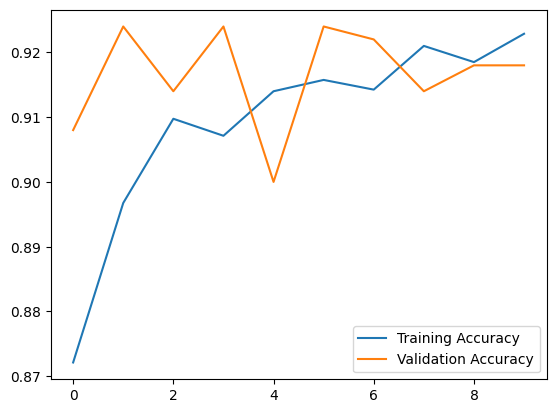

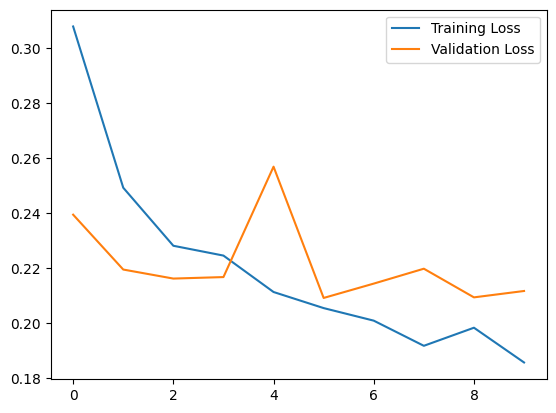

In [16]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [17]:
test_dir = os.path.join(dataset_path, 'Test')
print(test_dir)

/root/.cache/kagglehub/datasets/yasserhessein/gender-dataset/versions/1/Dataset/Test


In [18]:
# Define paths
new_tes_dir = "path/to/new_test_dire"  # Directory for the new test dataset

# Ensure the new test directory exists
os.makedirs(new_tes_dir, exist_ok=True)

# Function to create a subset of the test dataset
def create_test_subset(input_dir, output_dir, sample_size=500):
    """
    Create a subset of the test dataset with a specified number of images per class.

    Args:
        input_dir (str): Path to the original test directory.
        output_dir (str): Path to save the new test subset.
        sample_size (int): Number of images to copy per class.
    """
    for gender in ["Male", "Female"]:
        gender_dir = os.path.join(input_dir, gender)
        output_gender_dir = os.path.join(output_dir, gender)
        os.makedirs(output_gender_dir, exist_ok=True)

        # List all image files in the gender directory
        all_files = [f for f in os.listdir(gender_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly sample the specified number of files
        sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

        # Copy sampled files to the new directory
        for file_name in sampled_files:
            src_path = os.path.join(gender_dir, file_name)
            dest_path = os.path.join(output_gender_dir, file_name)
            shutil.copy(src_path, dest_path)

        print(f"Copied {len(sampled_files)} files to {output_gender_dir}")

# Create the subset
create_test_subset(test_dir, new_tes_dir, sample_size=500)


Copied 500 files to path/to/new_test_dire/Male
Copied 500 files to path/to/new_test_dire/Female


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    new_tes_dir,
    target_size=(128, 128),  # Match input size of the model
    batch_size=64,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


In [20]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Loss:",test_loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 891ms/step - accuracy: 0.9179 - loss: 0.1967
Test Accuracy: 92.80%
Loss: 0.18704693019390106


16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


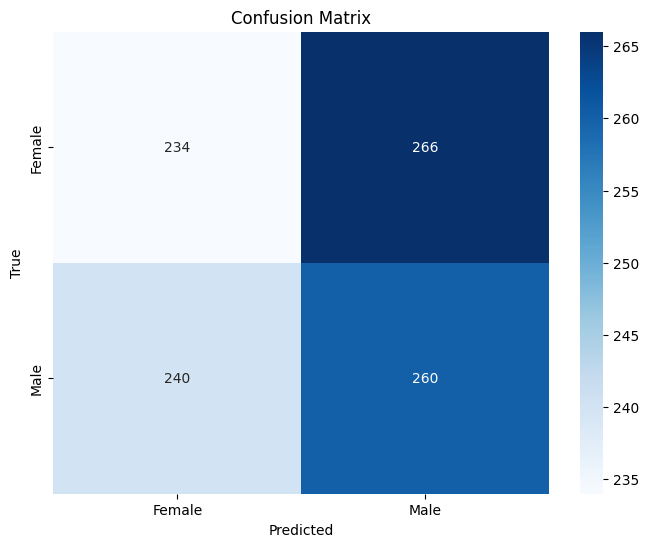

              precision    recall  f1-score   support

      Female       0.49      0.47      0.48       500
        Male       0.49      0.52      0.51       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int")

# Confusion matrix and report
cm=confusion_matrix(y_true, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Visualize classification report
print(classification_report(y_true, y_pred, target_names=["Female", "Male"]))

In [22]:
!pip install cvlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 85.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046369 sha256=f9a67e8486d7227c5aa7862151b9ced3c616569b5b1c99664ec3fcfb0277ec0f
  Stored in directory: /root/.cache/pip/wheels/9e/a5/d4/fe37b48fe4f4b621ba5e574a991230070f3cc4f02322a01489
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12066 sha256=6b4fd252f2da6751c9736d8108f80676baddfa8e341ee499dd1a29051903b753
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built cvlib progressbar


In [23]:
import cvlib as cv
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [25]:
# Loading Model
model=load_model('Gender_Detection_SJ.keras')

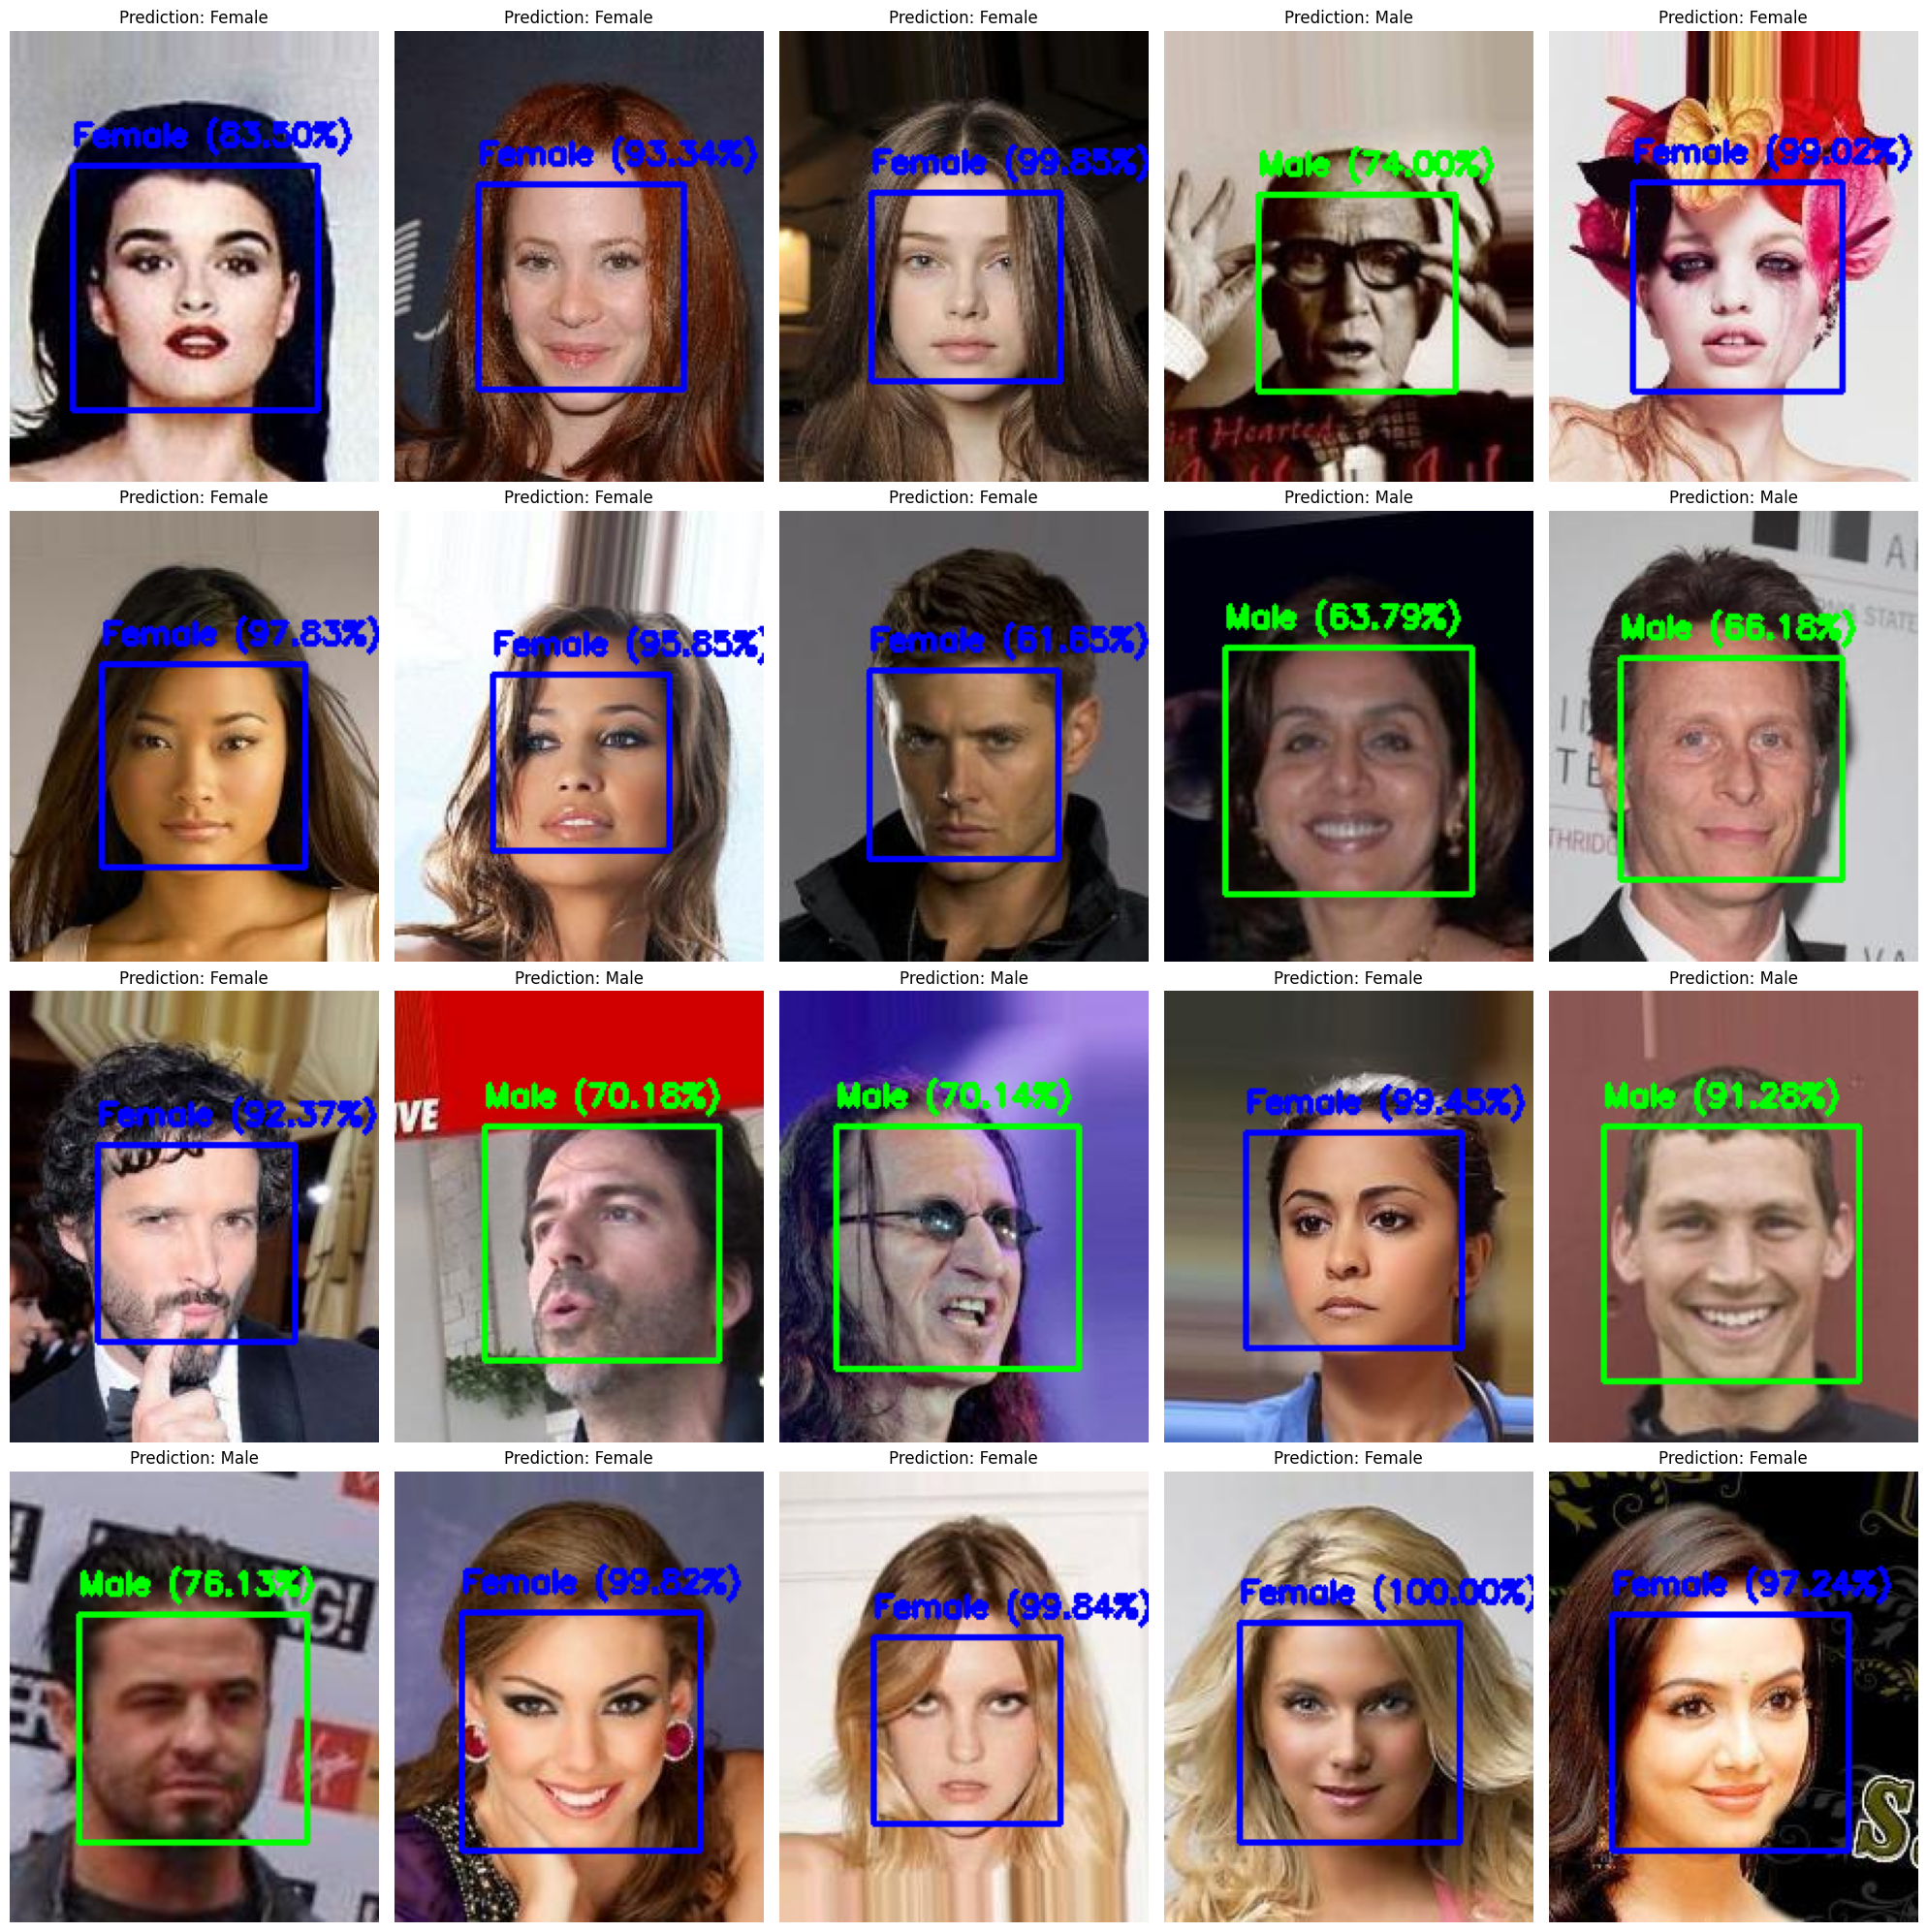

In [29]:
# Load Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def preprocess_image(face):
    """
    Resize, normalize, and prepare the image for the model.
    """
    face = cv2.resize(face, (128, 128))  # Resize to match model's input size
    face = face / 255.0  # Normalize pixel values
    face = np.expand_dims(face, axis=0)  # Add batch dimension
    return face

# Path to your training dataset
train_dir = new_tes_dir

# Select 20 random images from subdirectories (e.g., Male and Female folders)
image_paths = []
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        image_paths += [os.path.join(label_dir, fname) for fname in os.listdir(label_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly sample 20 images
sample_image_paths = random.sample(image_paths, 20)

processed_images = []  # For visualization
predictions = []  # Store predictions

for img_path in sample_image_paths:
    # Read and process the image
    img = cv2.imread(img_path)
    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for face detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    for (x, y, w, h) in faces:
        # Crop and preprocess the face
        face = img[y:y+h, x:x+w]
        preprocessed_face = preprocess_image(face)

        # Predict gender
        prediction = model.predict(preprocessed_face, verbose=0)
        probability = prediction[0][0]
        gender = "Male" if probability > 0.5 else "Female"
        confidence = probability * 100 if probability > 0.5 else (1 - probability) * 100

        # Annotate the image
        label = f"{gender} ({confidence:.2f}%)"
        color = (0, 255, 0) if gender == "Male" else (255, 0, 0)
        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Append processed image for visualization
    processed_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    predictions.append(gender)

# Display processed images with predictions
n_images = len(processed_images)
cols = 5  # Number of images per row
rows = (n_images + cols - 1) // cols  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i in range(len(axes)):
    if i < n_images:
        axes[i].imshow(processed_images[i])
        axes[i].axis('off')  # Hide axis for better display
        axes[i].set_title(f"Prediction: {predictions[i]}")
    else:
        axes[i].axis('off')  # Turn off unused subplots

plt.tight_layout()
plt.show()
